# File and libraries

In [1]:
import pandas as pd
import numpy as np


filepath=r'data/df_merch_7_bal_input'
test_filepath= f"{filepath}_test.csv"
train_filepath= f"{filepath}_train.csv"

file_tag = "df_merch_final"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"


# Data functions

In [3]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [4]:

# test_data=True
test_data=False

# use to evaluate strategies. otherwise False to just transform data 
evaluate=True
# evaluate=False


if test_data==True:

    data=pd.read_csv(f"{filepath}.csv")
    
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # sample
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.01)).reset_index(drop=True)

    data=data.sample(frac=0.05, replace=False)
    test=test.sample(frac=0.05, replace=False)
    train=train.sample(frac=0.05, replace=False)
    
    
else:
    data=pd.read_csv(f"{filepath}.csv")  
    test= pd.read_csv(test_filepath)
    train= pd.read_csv(train_filepath)

    # larger sample 10%
    data = data.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    test = test.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)
    train = train.groupby('day_of_year').apply(lambda x: sample_per_day(x, 0.1)).reset_index(drop=True)



 
target='returning_user'
vars: list[str] = data.columns.to_list()
labels: list = list(data[target].unique())


# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)
test.sort_values(by='day_of_year', inplace=True)
train.sort_values(by='day_of_year', inplace=True)



data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383798 entries, 0 to 383797
Data columns (total 40 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   device_category                  383798 non-null  float64
 1   device_mobile_model_name         383798 non-null  float64
 2   device_operating_system          383798 non-null  float64
 3   device_operating_system_version  383798 non-null  float64
 4   device_language                  383798 non-null  float64
 5   device_web_info_browser          383798 non-null  float64
 6   device_web_info_browser_version  383798 non-null  float64
 7   geo_region                       383798 non-null  float64
 8   geo_city                         383798 non-null  float64
 9   traffic_source_medium            383798 non-null  float64
 10  traffic_source_source            383798 non-null  float64
 11  engagement_time_msec             383798 non-null  float64
 12  month  

# Distribution Check

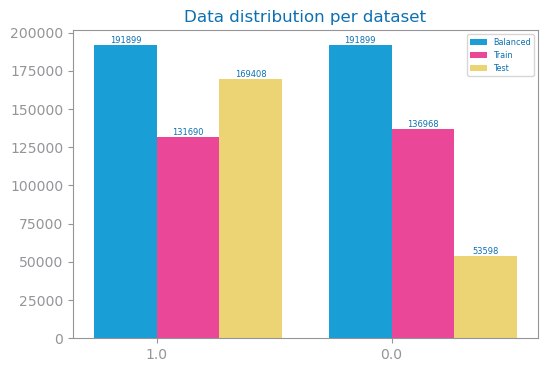

In [5]:
from pandas import concat
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart


# Distribution check


# Create a dictionary to store original class counts
values: dict[str, list[int]] = {
    "Balanced": [
        len(data[data[target] == 0]),  # Assuming 0 is the negative class
        len(data[data[target] == 1]),  # Assuming 1 is the positive class
    ]
}

values["Train"] = [
    len(train[train[target] == 0]),
    len(train[train[target] == 1]),
]
values["Test"] = [
    len(test[test[target] == 0]),
    len(test[test[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Evaluate for best model - Gradient Boosting

Train#=268658 Test#=223006
Labels=[0.0, 1.0]


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

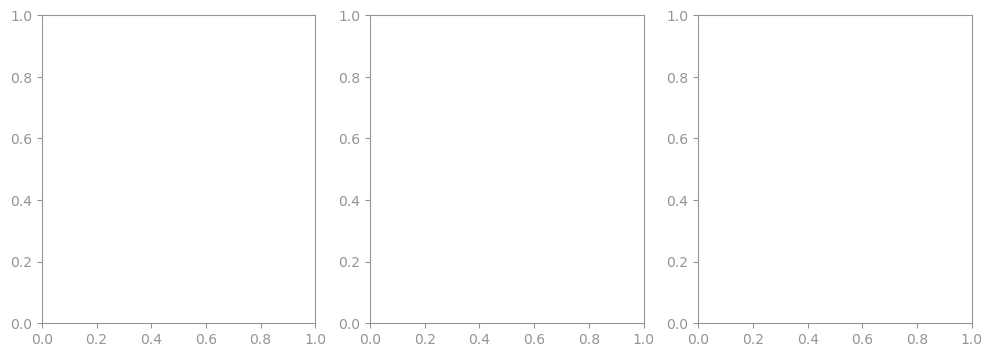

In [6]:
if evaluate==True:

    trnX, tstX, trnY, tstY, labels, vars = read_train_test_from_files(train, test, target)
    print(f'Train#={len(trnX)} Test#={len(tstX)}')
    print(f'Labels={labels}')

    figure()

    eval_metric = 'f1'

    best_model, params = gradient_boosting_study(
    trnX,
    trnY,
    tstX,
    tstY,
    nr_max_trees=1000,
    lag=250,
    metric=eval_metric,
    )
    
    savefig(f'images/{file_tag}_dt_{eval_metric}_study.png')
    show()
    

# Best Model Performance

<Figure size 640x480 with 0 Axes>

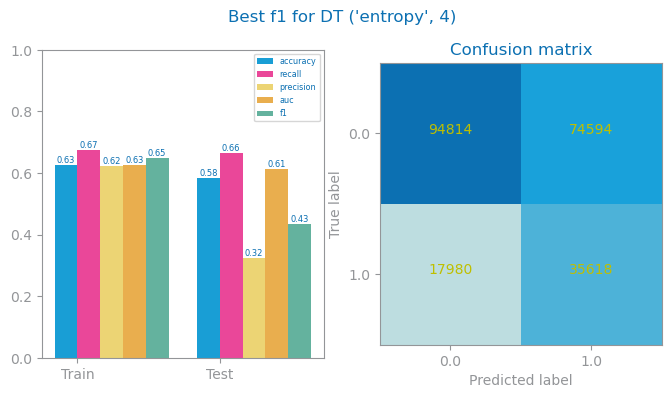

In [36]:
if evaluate == True:
    prd_trn: array = best_model.predict(trnX)
    prd_tst: array = best_model.predict(tstX)
    figure()
    plot_evaluation_results(params, trnY, prd_trn, tstY, prd_tst, labels)
    savefig(f'images/{file_tag}_dt_{params["name"]}_best_{params["metric"]}_eval.png')
    show()

# Variables importance


In [1]:
if evaluate==True:
    from numpy import std, argsort
    from dslabs_functions import plot_horizontal_bar_chart

    trees_importances: list[float] = []
    for lst_trees in best_model.estimators_:
        for tree in lst_trees:
            trees_importances.append(tree.feature_importances_)

    stdevs: list[float] = list(std(trees_importances, axis=0))
    importances = best_model.feature_importances_
    indices: list[int] = argsort(importances)[::-1]
    elems: list[str] = []
    imp_values: list[float] = []
    for f in range(len(vars)):
        elems += [vars[indices[f]]]
        imp_values.append(importances[indices[f]])
        print(f"{f+1}. {elems[f]} ({importances[indices[f]]})")

    figure()
    plot_horizontal_bar_chart(
        elems,
        imp_values,
        error=stdevs,
        title="GB variables importance",
        xlabel="importance",
        ylabel="variables",
        percentage=True,
    )
    savefig(f"images/{file_tag}_gb_{eval_metric}_vars_ranking.png")

NameError: name 'evaluate' is not defined

# Overfitting

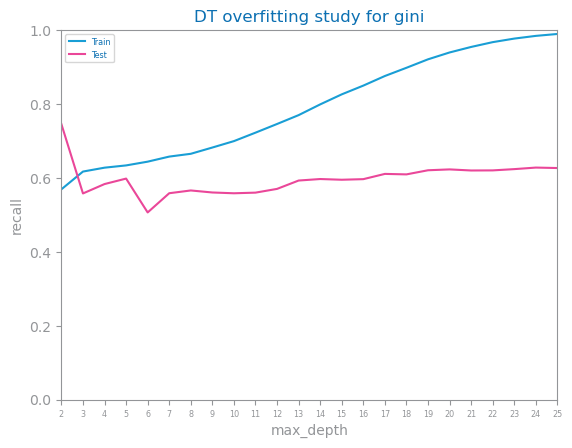

In [33]:
if evaluate==True:
    
    d_max: int = params["params"][0]
    lr: float = params["params"][1]
    nr_estimators: list[int] = [i for i in range(2, 2501, 500)]

    y_tst_values: list[float] = []
    y_trn_values: list[float] = []
    acc_metric: str = "accuracy"

    for n in nr_estimators:
        clf = GradientBoostingClassifier(n_estimators=n, max_depth=d_max, learning_rate=lr)
        clf.fit(trnX, trnY)
        prd_tst_Y: array = clf.predict(tstX)
        prd_trn_Y: array = clf.predict(trnX)
        y_tst_values.append(CLASS_EVAL_METRICS[acc_metric](tstY, prd_tst_Y))
        y_trn_values.append(CLASS_EVAL_METRICS[acc_metric](trnY, prd_trn_Y))

    figure()
    plot_multiline_chart(
        nr_estimators,
        {"Train": y_trn_values, "Test": y_tst_values},
        title=f"GB overfitting study for d={d_max} and lr={lr}",
        xlabel="nr_estimators",
        ylabel=str(eval_metric),
        percentage=True,
    )
    savefig(f"images/{file_tag}_gb_{eval_metric}_overfitting.png")

# Analysis

- Traffic source and medium with higher importance
- overfitting from level 3
